In [47]:
# 辨識類別 (請用英文、無空格)
category_en = "shiba,samoyed,border_collie"

# 辨識類別的中文, 顯示時用的名稱
category_zh = "柴犬,薩摩耶,邊境牧羊犬"

# APP 的名稱, 可自由更改
title = "狗狗辨識器"

# APP 的說明, 可自由更改
description="請輸入要辨識之狗圖！"

### 1. 安裝和讀入需要的套件

In [48]:
!pip install gradio

In [49]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [51]:
import os
import zipfile
import PIL.Image as Image
import gradio as gr

### 2. 創建資料夾

In [52]:
categories = category_en.split(',')
labels = category_zh.split(',')

In [53]:
# 辨識有幾類
N = len(categories)

In [54]:
base_dir = '/content/'

In [55]:
for category in categories:
    os.makedirs(f'./{category}', exist_ok=True)

這邊是到自己的git把圖片載入

In [56]:
!wget --no-check-certificate \
    https://github.com/yuheng1010/ai_detection/raw/main/img/ai_dect_pic.zip \
    -O /content/ai_dect_pic.zip

--2024-05-05 06:30:53--  https://github.com/yuheng1010/ai_detection/raw/main/img/ai_dect_pic.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yuheng1010/ai_detection/main/img/ai_dect_pic.zip [following]
--2024-05-05 06:30:53--  https://raw.githubusercontent.com/yuheng1010/ai_detection/main/img/ai_dect_pic.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 567821 (555K) [application/zip]
Saving to: ‘/content/ai_dect_pic.zip’

/content/ai_dect_pi 100%[===================>] 554.51K  --.-KB/s    in 0.05s   

2024-05-05 06:30:53 (12.0 MB/s) - ‘/content/ai_dect_pic.zip’ saved [567821/567821]



In [57]:
local_zip = '/content/ai_dect_pic.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

我們可以列出在某個資料夾的檔名! （這邊是列出柴犬資料夾的）

In [58]:
thedir = base_dir +"ai_dect_pic/"+ categories[0] #列出柴犬資料夾裡的圖片
os.listdir(thedir)

['.DS_Store',
 'shiba02.jpg',
 'shiba03.jpg',
 'shiba09.jpg',
 'shiba04.jpg',
 'shiba08.jpg',
 'shiba01.jpg',
 'shiba07.jpg',
 'shiba05.jpg',
 'shiba06.jpg',
 'shiba10.jpg']

接下來，我們要將這三個資料夾底下的照片作成輸入 (data)、輸出 (target)。

In [59]:
data = []
target = []
for i in range(0,3):
    thedir = base_dir +"ai_dect_pic/"+ categories[i]
    file_names = os.listdir(thedir)
    for fname in file_names:
        if fname == ".DS_Store":
          continue
        img_path = thedir + '/' + fname
        img = load_img(img_path , target_size = (224,224))
        x = img_to_array(img)
        data.append(x)
        target.append(i)

In [60]:
data = np.array(data)

看總共有多少張圖片

In [61]:
data.shape

(30, 224, 224, 3)

隨機挑一張照片來看看它是什麼狗

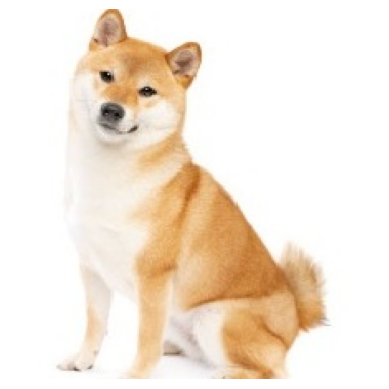

In [62]:
n = 1
plt.imshow(data[n]/255)
plt.axis('off');

In [63]:
x_train = preprocess_input(data)

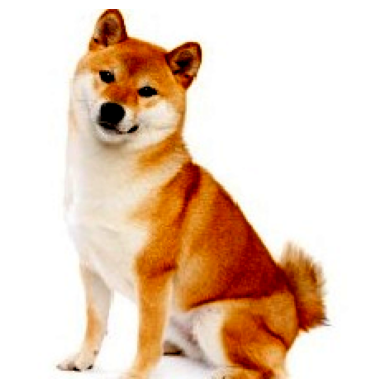

In [64]:
plt.imshow(x_train[n])
plt.axis('off');

In [65]:
target[n]

0

做 one-hot enconding。

In [66]:
y_train = to_categorical(target, N)

In [67]:
y_train[0]

array([1., 0., 0.], dtype=float32)

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global average pooling), 這本來該我們自己做, 但是 `tf.Keras` 已幫我們做好。只要下個參數 `pooling="avg"`)。

In [68]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [69]:
resnet = ResNet50V2(include_top=False, pooling="avg")

再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [70]:
model = Sequential()

In [71]:
model.add(resnet)

In [72]:
model.add(Dense(N, activation='softmax'))

我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [73]:
resnet.trainable = False

#### 欣賞我們的神經網路

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23570947 (89.92 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 4. 訓練 fit

In [76]:
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
3/3 [==============================] - 4s 61ms/step - loss: 1.1196 - accuracy: 0.4333
Epoch 2/10
3/3 [==============================] - 0s 70ms/step - loss: 0.4418 - accuracy: 0.9000
Epoch 3/10
3/3 [==============================] - 0s 46ms/step - loss: 0.1956 - accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 0s 35ms/step - loss: 0.0920 - accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 0s 48ms/step - loss: 0.0465 - accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 0s 42ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 0s 36ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 0s 36ms/step - loss: 0.0076 - accuracy: 1.0000
Epoch 10/10
3/3 [==============================] - 0s 43ms/step - loss: 0.0062 - accuracy: 1.0000


### 5. 預測

我們先用 model.evaluate 看一下模型表現得如何

In [77]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

1/1 [==============================] - 2s 2s/step - loss: 0.0054 - accuracy: 1.0000
Loss: 0.005355547647923231
Accuracy: 1.0


In [78]:
y_predict = np.argmax(model.predict(x_train), -1)

1/1 [==============================] - 3s 3s/step


In [79]:
y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [80]:
target

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

### 6. 用 `gradio` 打造狗狗辨識 web app

In [81]:
def resize_image(inp):
    # 將 NumPy array 轉換成 PIL Image 對象
    img = Image.fromarray(inp)

    # 將圖片調整為 224x224 像素
    img_resized = img.resize((224, 224), Image.Resampling.LANCZOS)

    # 將調整大小後的圖片轉換回 NumPy array
    img_array = np.array(img_resized)

    return img_array

In [82]:
def classify_image(inp):
    img_array = resize_image(inp)
    inp = img_array.reshape((1, 224, 224, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(3)}

In [83]:
image = gr.Image(label="狗狗照片")
label = gr.Label(num_top_classes=N, label="AI辨識結果")

In [84]:
sample_images = []
for i in range(3):
    thedir = base_dir + categories[i]
    for fname in os.listdir(thedir):
        sample_images.append(categories[i] + '/' + fname)

In [85]:
gr.Interface(fn=classify_image,
             inputs=image,
             outputs=label,
             title=title,
             description=description,
             examples=sample_images).launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4b16f26e34e3ea5e71.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 22ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4b16f26e34e3ea5e71.gradio.live
